In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(""))))
from src.pre_process.feature_add import FeatureAddition
from src.pre_process.feature_duplicate import FeatureDuplication

In [3]:
BASE_PATH = r'C:\Users\com\Documents\GitHub\level2-competitiveds-recsys-06\data\etc'
data = pd.read_csv(os.path.join(BASE_PATH, 'v4_baek+recent+rank.csv'))
# train_data = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
# test_data = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

---

# data 확인

In [4]:
data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,has_high_school_within_1km,nearest_park_distance,nearest_park_within_500.0m,has_park_within_500.0m,apt_deposit_rank,apt_area_deposit_rank,original_index,recent_deposit,interest_rate,diff_interest_rate
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,...,1,498.618918,1,1,7683,29300,0,NaN,1.78,-0.07
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,...,1,498.618918,1,1,7683,29300,1,17000.0,1.26,-0.17
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,...,1,498.618918,1,1,7683,29300,2,23000.0,1.26,-0.17
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,...,1,169.839678,3,1,18366,58901,3,NaN,1.68,-0.10
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,...,0,382.401815,1,1,18369,58863,4,NaN,1.85,-0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,115.5101,202402,27,0,17,2010,37.528394,126.659398,14,...,1,398.113485,1,1,6088,25360,150167,37000.0,3.62,-0.04
1951396,150168,142.8738,202403,2,0,4,2010,37.528394,126.659398,14,...,1,398.113485,1,1,6088,17911,150168,43000.0,3.59,-0.03
1951397,150169,142.8738,202403,16,1,13,2010,37.528394,126.659398,14,...,1,398.113485,1,1,6088,17911,150169,43000.0,3.59,-0.03
1951398,150170,114.9285,202403,22,1,2,2010,37.528394,126.659398,14,...,1,398.113485,1,1,6088,24128,150170,32500.0,3.59,-0.03


In [5]:
data.columns

Index(['index', 'area_m2', 'contract_year_month', 'contract_day',
       'contract_type', 'floor', 'built_year', 'latitude', 'longitude', 'age',
       'deposit', '_type', 'apt_idx', 'area', 'area_price', 'area_m2_price',
       'grid_id', 'nearest_subway_distance', 'nearest_subway_idx',
       'num_subway_within_1km', 'category_interchange_within_1km',
       'num_subway_within_500m', 'category_interchange_within_500m',
       'nearest_elementary_school_distance',
       'nearest_elementary_school_within_1km',
       'has_elementary_school_within_1km', 'nearest_middle_school_distance',
       'nearest_middle_school_within_1km', 'has_middle_school_within_1km',
       'nearest_high_school_distance', 'nearest_high_school_within_1km',
       'has_high_school_within_1km', 'nearest_park_distance',
       'nearest_park_within_500.0m', 'has_park_within_500.0m',
       'apt_deposit_rank', 'apt_area_deposit_rank', 'original_index',
       'recent_deposit', 'interest_rate', 'diff_interest_rate']

---

# 추가 EDA

## contract_type one-hot encoding

In [6]:
# contract_type one-hot encoding
data = pd.get_dummies(data, columns=['contract_type'], prefix='contract')

In [7]:
data.drop(columns='contract_2', inplace=True)

In [8]:
data

,index,area_m2,contract_year_month,contract_day,floor,built_year,latitude,longitude,age,deposit,...,nearest_park_within_500.0m,has_park_within_500.0m,apt_deposit_rank,apt_area_deposit_rank,original_index,recent_deposit,interest_rate,diff_interest_rate,contract_0,contract_1
0,0,84.9981,201906,25,9,2019,37.054314,127.045216,0,17000.0,...,1,1,7683,29300,0,NaN,1.78,-0.07,False,False
1,1,84.9981,202003,26,20,2019,37.054314,127.045216,1,23000.0,...,1,1,7683,29300,1,17000.0,1.26,-0.17,False,False
2,2,84.9981,202003,28,8,2019,37.054314,127.045216,1,23000.0,...,1,1,7683,29300,2,23000.0,1.26,-0.17,False,False
3,3,59.3400,201907,15,1,1986,36.964647,127.055847,33,5000.0,...,3,1,18366,58901,3,NaN,1.68,-0.10,False,False
4,4,59.8100,201904,12,6,1995,36.972390,127.084514,24,1800.0,...,1,1,18369,58863,4,NaN,1.85,-0.09,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,115.5101,202402,27,17,2010,37.528394,126.659398,14,NaN,...,1,1,6088,25360,150167,37000.0,3.62,-0.04,True,False
1951396,150168,142.8738,202403,2,4,2010,37.528394,126.659398,14,NaN,...,1,1,6088,17911,150168,43000.0,3.59,-0.03,True,False
1951397,150169,142.8738,202403,16,13,2010,37.528394,126.659398,14,NaN,...,1,1,6088,17911,150169,43000.0,3.59,-0.03,False,True
1951398,150170,114.9285,202403,22,2,2010,37.528394,126.659398,14,NaN,...,1,1,6088,24128,150170,32500.0,3.59,-0.03,False,True


## contract_year_month + contract_day

In [9]:
data['contract_year_month'] = data['contract_year_month'].astype(str)

# 'contract_day'를 두 자리로 맞추기 위한 처리
data['contract_day'] = data['contract_day'].apply(lambda x: f"{x:02d}")

# 날짜 형식으로 결합
data['contract_date'] = pd.to_datetime(data['contract_year_month'] + data['contract_day'], format='%Y%m%d')

In [10]:
data

,index,area_m2,contract_year_month,contract_day,floor,built_year,latitude,longitude,age,deposit,...,has_park_within_500.0m,apt_deposit_rank,apt_area_deposit_rank,original_index,recent_deposit,interest_rate,diff_interest_rate,contract_0,contract_1,contract_date
0,0,84.9981,201906,25,9,2019,37.054314,127.045216,0,17000.0,...,1,7683,29300,0,NaN,1.78,-0.07,False,False,2019-06-25
1,1,84.9981,202003,26,20,2019,37.054314,127.045216,1,23000.0,...,1,7683,29300,1,17000.0,1.26,-0.17,False,False,2020-03-26
2,2,84.9981,202003,28,8,2019,37.054314,127.045216,1,23000.0,...,1,7683,29300,2,23000.0,1.26,-0.17,False,False,2020-03-28
3,3,59.3400,201907,15,1,1986,36.964647,127.055847,33,5000.0,...,1,18366,58901,3,NaN,1.68,-0.10,False,False,2019-07-15
4,4,59.8100,201904,12,6,1995,36.972390,127.084514,24,1800.0,...,1,18369,58863,4,NaN,1.85,-0.09,False,False,2019-04-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,115.5101,202402,27,17,2010,37.528394,126.659398,14,NaN,...,1,6088,25360,150167,37000.0,3.62,-0.04,True,False,2024-02-27
1951396,150168,142.8738,202403,02,4,2010,37.528394,126.659398,14,NaN,...,1,6088,17911,150168,43000.0,3.59,-0.03,True,False,2024-03-02
1951397,150169,142.8738,202403,16,13,2010,37.528394,126.659398,14,NaN,...,1,6088,17911,150169,43000.0,3.59,-0.03,False,True,2024-03-16
1951398,150170,114.9285,202403,22,2,2010,37.528394,126.659398,14,NaN,...,1,6088,24128,150170,32500.0,3.59,-0.03,False,True,2024-03-22


In [11]:
data['contract_date_numeric'] = data['contract_date'].dt.strftime('%Y%m%d').astype(int)

In [12]:
data

,index,area_m2,contract_year_month,contract_day,floor,built_year,latitude,longitude,age,deposit,...,apt_deposit_rank,apt_area_deposit_rank,original_index,recent_deposit,interest_rate,diff_interest_rate,contract_0,contract_1,contract_date,contract_date_numeric
0,0,84.9981,201906,25,9,2019,37.054314,127.045216,0,17000.0,...,7683,29300,0,NaN,1.78,-0.07,False,False,2019-06-25,20190625
1,1,84.9981,202003,26,20,2019,37.054314,127.045216,1,23000.0,...,7683,29300,1,17000.0,1.26,-0.17,False,False,2020-03-26,20200326
2,2,84.9981,202003,28,8,2019,37.054314,127.045216,1,23000.0,...,7683,29300,2,23000.0,1.26,-0.17,False,False,2020-03-28,20200328
3,3,59.3400,201907,15,1,1986,36.964647,127.055847,33,5000.0,...,18366,58901,3,NaN,1.68,-0.10,False,False,2019-07-15,20190715
4,4,59.8100,201904,12,6,1995,36.972390,127.084514,24,1800.0,...,18369,58863,4,NaN,1.85,-0.09,False,False,2019-04-12,20190412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,115.5101,202402,27,17,2010,37.528394,126.659398,14,NaN,...,6088,25360,150167,37000.0,3.62,-0.04,True,False,2024-02-27,20240227
1951396,150168,142.8738,202403,02,4,2010,37.528394,126.659398,14,NaN,...,6088,17911,150168,43000.0,3.59,-0.03,True,False,2024-03-02,20240302
1951397,150169,142.8738,202403,16,13,2010,37.528394,126.659398,14,NaN,...,6088,17911,150169,43000.0,3.59,-0.03,False,True,2024-03-16,20240316
1951398,150170,114.9285,202403,22,2,2010,37.528394,126.659398,14,NaN,...,6088,24128,150170,32500.0,3.59,-0.03,False,True,2024-03-22,20240322


In [13]:
data.columns

Index(['index', 'area_m2', 'contract_year_month', 'contract_day', 'floor',
       'built_year', 'latitude', 'longitude', 'age', 'deposit', '_type',
       'apt_idx', 'area', 'area_price', 'area_m2_price', 'grid_id',
       'nearest_subway_distance', 'nearest_subway_idx',
       'num_subway_within_1km', 'category_interchange_within_1km',
       'num_subway_within_500m', 'category_interchange_within_500m',
       'nearest_elementary_school_distance',
       'nearest_elementary_school_within_1km',
       'has_elementary_school_within_1km', 'nearest_middle_school_distance',
       'nearest_middle_school_within_1km', 'has_middle_school_within_1km',
       'nearest_high_school_distance', 'nearest_high_school_within_1km',
       'has_high_school_within_1km', 'nearest_park_distance',
       'nearest_park_within_500.0m', 'has_park_within_500.0m',
       'apt_deposit_rank', 'apt_area_deposit_rank', 'original_index',
       'recent_deposit', 'interest_rate', 'diff_interest_rate', 'contract_0',
  

---

In [14]:
train_data = data[data['_type'] == 'train']
test_data = data[data['_type'] == 'test']

In [15]:
column_needed = [
    # 'index', '_type', 'area_price', 'area_m2_price', 'original_index', 'contract_type','contract_year_month', 'contract_day',
    'area_m2', 'contract_date_numeric',
    'floor', 'built_year', 'latitude', 'longitude', 'age',
    'contract_0', 'contract_1',
    'deposit',
    'apt_idx',
    'area',
    'grid_id',
    'nearest_subway_distance',
    'nearest_subway_idx',
    # 'num_subway_within_1km',
    # 'category_interchange_within_1km',
    # 'num_subway_within_500m', 
    # 'category_interchange_within_500m',
    'nearest_elementary_school_distance',
    # 'nearest_elementary_school_within_1km',
    # 'has_elementary_school_within_1km',
    'nearest_middle_school_distance',
    # 'nearest_middle_school_within_1km',
    # 'has_middle_school_within_1km',
    'nearest_high_school_distance',
    # 'nearest_high_school_within_1km',
    # 'has_high_school_within_1km',
    'nearest_park_distance',
    # 'nearest_park_within_500.0m',
    # 'has_park_within_500.0m',
    'apt_deposit_rank', 'apt_area_deposit_rank',
    'recent_deposit',
    # 'interest_rate', 
    # 'diff_interest_rate',
]
test_column_needed = [
    # 'index', '_type', 'area_price', 'area_m2_price', 'original_index','deposit', 'contract_type','contract_year_month', 'contract_day',
    'area_m2', 'contract_date_numeric',
    'floor', 'built_year', 'latitude', 'longitude', 'age',
    'contract_0', 'contract_1',
    'apt_idx',
    'area',
    'grid_id',
    'nearest_subway_distance',
    'nearest_subway_idx',
    # 'num_subway_within_1km',
    # 'category_interchange_within_1km',
    # 'num_subway_within_500m', 
    # 'category_interchange_within_500m',
    'nearest_elementary_school_distance',
    # 'nearest_elementary_school_within_1km',
    # 'has_elementary_school_within_1km',
    'nearest_middle_school_distance',
    # 'nearest_middle_school_within_1km',
    # 'has_middle_school_within_1km',
    'nearest_high_school_distance',
    # 'nearest_high_school_within_1km',
    # 'has_high_school_within_1km',
    'nearest_park_distance',
    # 'nearest_park_within_500.0m',
    # 'has_park_within_500.0m',
    'apt_deposit_rank', 'apt_area_deposit_rank',
    'recent_deposit',
    # 'interest_rate', 
    # 'diff_interest_rate',
]
train_df = train_data[column_needed]
test_df = test_data[test_column_needed]

In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# # 학습에 사용할 특징 열
# feature_columns = [col for col in data.columns if col not in ['deposit', '_type', 'index']]
# 학습 및 테스트 데이터 준비
X_train = train_df.drop(columns=['deposit'])
y_train = train_df['deposit']
X_test = test_df.copy()
# 학습 데이터를 검증용으로 분할
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2,
                                                                          random_state=42)
# XGBoost를 위한 DMatrix 생성
dtrain = xgb.DMatrix(X_train_split, label=y_train_split)
dval = xgb.DMatrix(X_val_split, label=y_val_split)
dtest = xgb.DMatrix(X_test)
# XGBoost 파라미터 설정
params = {
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}
# 모델 학습
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=500, early_stopping_rounds=50, evals=evals, verbose_eval=10)
# 테스트 세트에 대한 예측
y_pred = model.predict(dtest)

[0]	train-mae:16481.68626	eval-mae:16483.59171
[10]	train-mae:11225.72265	eval-mae:11226.91871
[20]	train-mae:8108.91805	eval-mae:8105.18521
[30]	train-mae:6295.56200	eval-mae:6285.58688
[40]	train-mae:5310.21674	eval-mae:5297.53982
[50]	train-mae:4804.00591	eval-mae:4793.22904
[60]	train-mae:4528.39553	eval-mae:4520.66247
[70]	train-mae:4385.81897	eval-mae:4380.81641
[80]	train-mae:4313.19072	eval-mae:4309.80885
[90]	train-mae:4259.46995	eval-mae:4256.85637
[100]	train-mae:4216.82141	eval-mae:4215.46104
[110]	train-mae:4189.39050	eval-mae:4189.02694
[120]	train-mae:4161.44725	eval-mae:4162.15723
[130]	train-mae:4140.92874	eval-mae:4142.41622
[140]	train-mae:4121.64076	eval-mae:4124.18449
[150]	train-mae:4102.70014	eval-mae:4105.91142
[160]	train-mae:4087.60452	eval-mae:4091.47429
[170]	train-mae:4071.76162	eval-mae:4076.18817
[180]	train-mae:4059.83070	eval-mae:4064.87607
[190]	train-mae:4046.06138	eval-mae:4051.42016
[200]	train-mae:4035.86510	eval-mae:4042.04327
[210]	train-mae:4026

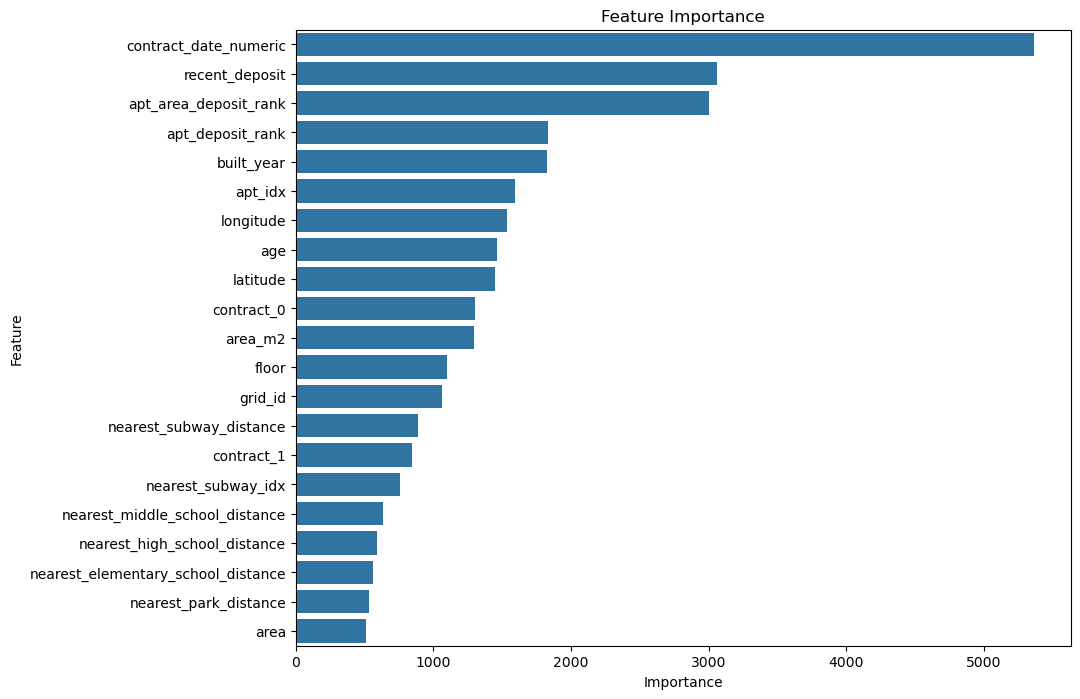

In [18]:
#Feature Importance
# 피처 중요도 추출
feature_importance = model.get_fscore()
# 피처 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame(feature_importance.items(), columns=['Feature', 'Importance'])
# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [19]:
y_pred

array([22589.986 ,  7497.9478,  6663.4443, ..., 44338.895 , 36943.223 ,
       38275.613 ], dtype=float32)

In [20]:
sample_submission['deposit'] = y_pred
sample_submission

,index,deposit
0,0,22589.986328
1,1,7497.947754
2,2,6663.444336
3,3,6830.994629
4,4,6900.933105
...,...,...
150167,150167,37501.769531
150168,150168,43911.636719
150169,150169,44338.894531
150170,150170,36943.222656


In [21]:
sample_submission.describe()

,index,deposit
count,150172.00000,150172.000000
mean,75085.50000,39073.144531
std,43351.06665,23854.933594
min,0.00000,3355.925293
25%,37542.75000,23099.062988
50%,75085.50000,33835.701172
75%,112628.25000,48468.089844
max,150171.00000,332553.968750


In [172]:
sample_submission.to_csv('v4_add(apt_floor_rank).csv', index=False)

---